## Cogs 118A - Final Project

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)

from ucimlrepo import fetch_ucirepo 
from numpy import int16
import warnings
warnings.filterwarnings("ignore")

## Functions for Plotting and Training Pipeline

In [2]:
# Useful functions
def plot_results(test_accuracy, yi, y_pred):
    # Define colors for pie plot
    custom_colors = ['#ff5733', '#66b3ff']  # A vibrant red and a bright blue

    # explode count, separate two sections
    explode = (0.1, 0)

    plt.figure(figsize=(12, 5))

    # Pie Plot for Model Accuracy Distributions
    plt.subplot(1, 2, 1)
    plt.pie(
        [test_accuracy, 1 - test_accuracy],
        explode=explode,
        colors=custom_colors,
        autopct=lambda p: f'{p:.1f}%',
        startangle=140,
        labels=['Correct', 'Incorrect']
    )
    plt.axis('equal')
    plt.title("Model Accuracy Distributions")

    # Confusion Matrix Plot
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_true=yi, y_pred=y_pred)
    print(cm)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Distribution of Prediction')

    plt.tight_layout()
    plt.show()

def print_results(results):
    splits = [0.2, 0.5, 0.8]
    for idx, result in enumerate(results):
        print(f'Test Size: {splits[idx]}')
        print(result)
        print('\n')

def dataset_summary(df):
    combined_df = pd.concat([df[0], df[1], df[2]], keys=['0.2', '0.5', '0.8'])

    combined_df.reset_index(inplace=True)
    combined_df.columns = ['Test Size', 'Model Name', 'Train Accuracy', 'Best Validation', 'Test Accuracy']
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=combined_df, x='Test Size', y='Test Accuracy', 
                hue='Model Name', style='Model Name', markers=True,
                dashes=False)
    plt.grid()
    plt.title('Test Size, Models and Test Accuracy', fontsize=18)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
    plt.show()

In [17]:
def train_model(X, y):

    test_sizes = [0.2, 0.5, 0.8]

    models = [LogisticRegression(max_iter=1100), DecisionTreeClassifier(max_depth=200),
               RandomForestClassifier(),  KNeighborsClassifier(), GradientBoostingClassifier()]

    names = ['Logistic Regression', 'Decision Tree', 'Random Forest',
              'KNN', 'Gradient Boosting']
    
    log_params = {
        'C': [0.1, 0.2, 0.4, 0.6, 0.8, 1],
        'class_weight': ['balanced']
    }

    rf_parameters = {
        'max_depth': [None, 20, 50],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [50, 100, 200]
    }

    dtc_params = {
        'max_depth': [None, 10, 20, 50, 100],
        'criterion': ['gini', 'entropy', 'log_loss']
    }

    gbc_params = {
        'loss': ['log_loss', 'deviance', 'exponential'],
        'n_estimators': [20, 50, 100],
        'max_depth' : [3, 5, 10]
    }

    knn_params = {
        'n_neighbors': [1, 3, 5, 7, 10]
    }

    # store evaluation results
    twenty = pd.DataFrame(columns=['Train Accuracy', 'Best Validation', 'Test Accuracy'], index=names)
    results = [twenty, twenty.copy(), twenty.copy()]

    best_accuracy = 0.0
    best_y_pred = None
    best_y = None
    best_para = None


    for i, size in enumerate(test_sizes):
            for idx, model in enumerate(models):
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=size, shuffle=True, random_state=42)
                
                if names[idx] == 'Logistic Regression':
                    model = GridSearchCV(estimator=model, param_grid=log_params, cv=3,
                                        scoring='accuracy', verbose=1, n_jobs=-1)
                    model.fit(X_train, y_train)
                    y_train_pred = model.best_estimator_.predict(X_train)
                    y_test_pred = model.best_estimator_.predict(X_test)
                    best_valid = model.cv_results_['mean_test_score'].max()
                elif names[idx] == 'Random Forest':
                    model = GridSearchCV(estimator=model, param_grid=rf_parameters, cv=3, 
                                        scoring='accuracy', n_jobs=-1, verbose=1)
                    model.fit(X_train, y_train)
                    y_train_pred = model.best_estimator_.predict(X_train)
                    y_test_pred = model.best_estimator_.predict(X_test)
                    best_valid = model.cv_results_['mean_test_score'].max()
                elif names[idx] == 'Gradient Boosting':
                    model = GridSearchCV(estimator=model, param_grid=gbc_params, cv=3, 
                                        scoring='accuracy', n_jobs=-1, verbose=1)
                    model.fit(X_train, y_train)
                    y_train_pred = model.best_estimator_.predict(X_train)
                    y_test_pred = model.best_estimator_.predict(X_test)
                    best_valid = np.nanmax(model.cv_results_['mean_test_score'])
                elif names[idx] == 'Decision Tree':
                    model = GridSearchCV(estimator=model, param_grid=dtc_params, cv=3, 
                                        scoring='accuracy', n_jobs=-1, verbose=1)
                    model.fit(X_train, y_train)
                    y_train_pred = model.best_estimator_.predict(X_train)
                    y_test_pred = model.best_estimator_.predict(X_test)
                    best_valid = model.cv_results_['mean_test_score'].max()
                else:
                    model = GridSearchCV(estimator=model, param_grid=knn_params, cv=3,
                                        scoring='accuracy', n_jobs=-1, verbose=1)
                    model.fit(X_train, y_train)
                    y_train_pred = model.best_estimator_.predict(X_train)
                    y_test_pred = model.best_estimator_.predict(X_test)
                    best_valid = model.cv_results_['mean_test_score'].max()
                    
                # Calculate accuracy
                train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
                test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)

                model_name = names[idx]
                results[i].loc[model_name, :] = [train_accuracy, best_valid, test_accuracy]
                
                # Check if the current model is the best one
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_y_pred = y_test_pred
                    best_y = y_test
                    best_para = model.best_params_

    return results, best_y, best_y_pred, best_para

### Dataset One - Bank Marketing

In [4]:
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 

# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets
y = pd.DataFrame([1 if each == 'yes' else 0 for each in y['y']], columns=['y'])
total = pd.concat([X, y], axis='columns')

In [5]:
# remove rows with NaN values, keep poutcome since most of them are missing
total = total.dropna(subset=['contact', 'pdays'])

In [7]:
total.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
12657,27,management,single,secondary,no,35,no,no,cellular,4,jul,255,1,-1,0,NaN,0
12658,54,blue-collar,married,primary,no,466,no,no,cellular,4,jul,297,1,-1,0,NaN,0
12659,43,blue-collar,married,secondary,no,105,no,yes,cellular,4,jul,668,2,-1,0,NaN,0
12660,31,technician,single,secondary,no,19,no,no,telephone,4,jul,65,2,-1,0,NaN,0
12661,27,technician,single,secondary,no,126,yes,yes,cellular,4,jul,436,4,-1,0,NaN,0


#### Data Preprocessing

In [6]:
total_ohe = pd.get_dummies(total, drop_first=True, dtype=int16)
correlation_matrix = total_ohe.corr()
correlation_with_G3 = correlation_matrix['y']

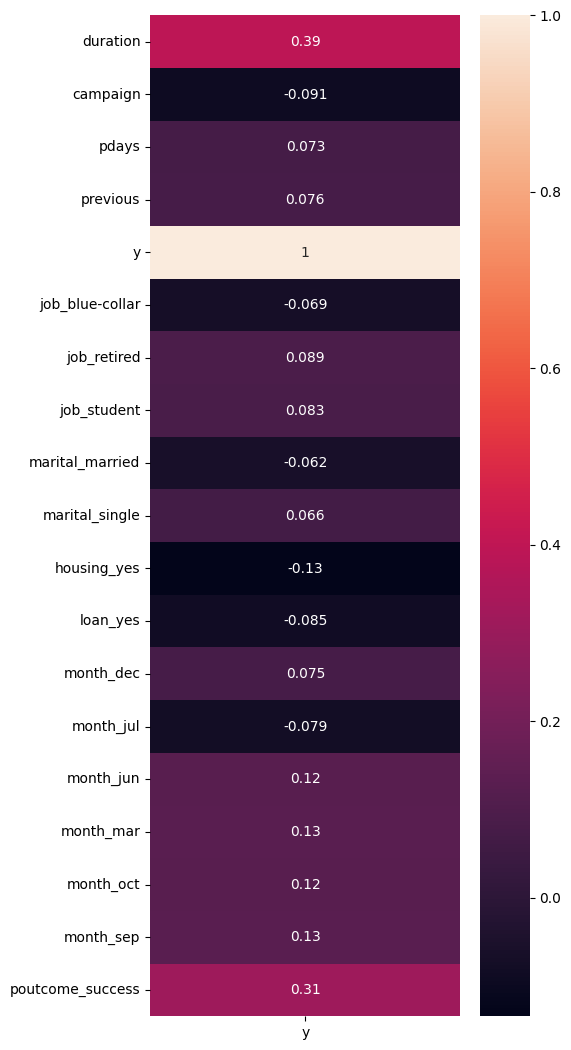

In [7]:
# select strong correlation columns as input features
THRESHOLD = 0.06
df_ohe_after_drop_features = total_ohe.copy()

for key, value in correlation_with_G3.items():
    if abs(value) < THRESHOLD:
        df_ohe_after_drop_features.drop(columns=key, inplace=True)

correlation_matrix = df_ohe_after_drop_features.corr()
correlation_with_y = correlation_matrix['y']

plt.figure(figsize=(5, 13))
sns.heatmap(correlation_with_y.to_frame(), annot=True, cbar=True)
plt.show()

In [8]:
y = df_ohe_after_drop_features['y']
X = df_ohe_after_drop_features.drop(['y'], axis='columns')

In [12]:
y.value_counts()

y
0    27432
1     4759
Name: count, dtype: int64

In [19]:
results, best_yi, best_ypred, best_para = train_model(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [20]:
best_para

{'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100}

In [21]:
print_results(results)

Test Size: 0.2
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.828169        0.828479      0.825749
Decision Tree             0.898299        0.873641      0.875291
Random Forest             0.912279        0.881912      0.879329
KNN                       0.879815        0.859351      0.866594
Gradient Boosting         0.888514        0.882961      0.882746


Test Size: 0.5
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.827027        0.824852       0.83089
Decision Tree             0.904318        0.870643      0.874254
Random Forest             0.909351        0.879093      0.882207
KNN                       0.878472        0.861386      0.861829
Gradient Boosting         0.889593        0.880646      0.885562


Test Size: 0.8
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.826188        0.823237      0.827904
Decision Tree             0.918453       

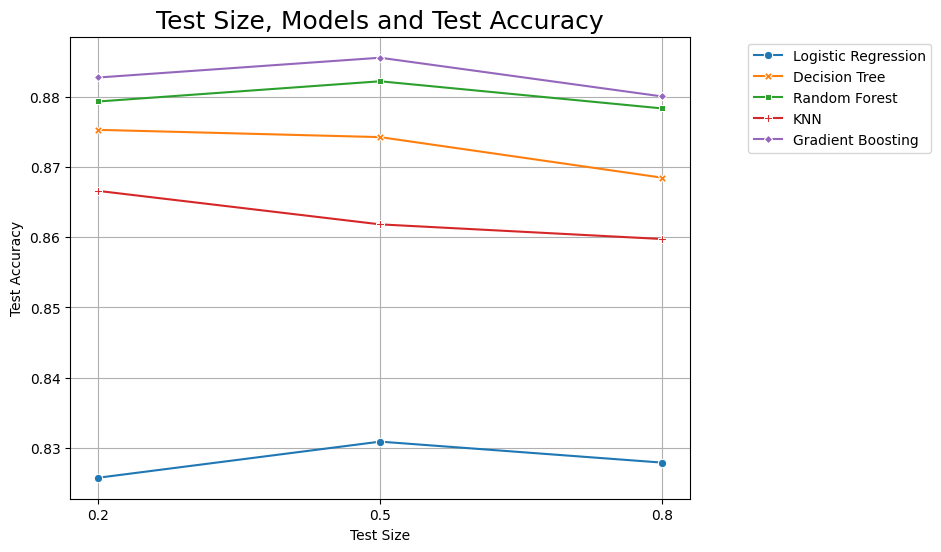

In [23]:
dataset_summary(results)

### Best Model Performance

[[13211   534]
 [ 1308  1043]]


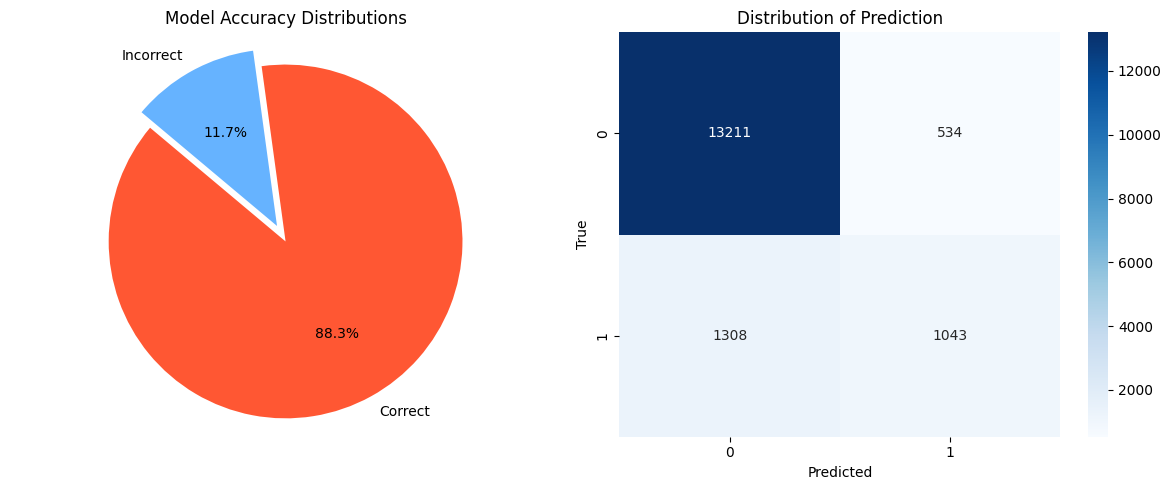

In [24]:
best_test_acc = results[0]['Test Accuracy'].max()
plot_results(best_test_acc, best_yi, best_ypred)

### Dataset 2: Student Performance

In [25]:
total = pd.read_csv('student/student-mat.csv', sep=';')

### Remove Outliers - possibly did not present in the exam

In [26]:
total.drop(total[total['G3'] < 1].index, inplace=True)

In [27]:
len(total)

357

In [28]:
total_ohe = pd.get_dummies(total, drop_first=True, dtype=int16)

In [29]:
correlation_matrix = total_ohe.corr()
correlation_with_G3 = correlation_matrix['G3']

In [30]:
# select strong correlation columns as input features
THRESHOLD = 0.1
df_ohe_after_drop_features = total_ohe.copy()

for key, value in correlation_with_G3.items():
    if abs(value) < THRESHOLD:
        df_ohe_after_drop_features.drop(columns=key, inplace=True)

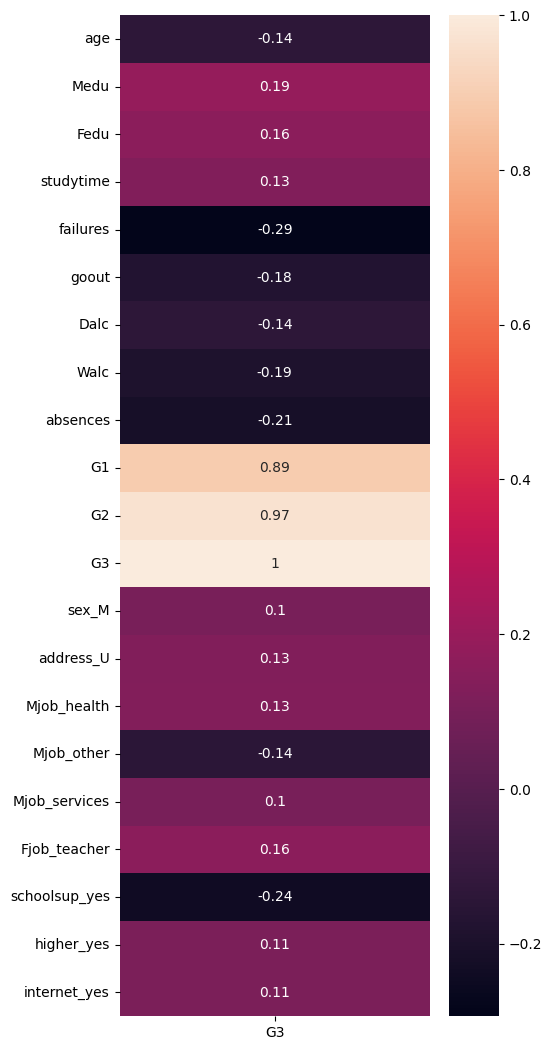

In [31]:
correlation_matrix = df_ohe_after_drop_features.corr()
correlation_with_y = correlation_matrix['G3']
df_ohe_after_drop_features.drop('age', axis='columns', inplace=True)

plt.figure(figsize=(5, 13))
sns.heatmap(correlation_with_y.to_frame(), annot=True, cbar=True)
plt.show()

In [32]:
X = df_ohe_after_drop_features.drop(columns=['G3'], axis='columns')
y = df_ohe_after_drop_features['G3'].apply(lambda x: 1 if x >= 10 else -1)

In [43]:
results, best_yi, best_ypred, best_para = train_model(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [44]:
best_para

{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100}

In [45]:
print_results(results)

Test Size: 0.2
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.915789        0.908772      0.902778
Decision Tree                  1.0        0.891228      0.902778
Random Forest             0.982456        0.908772      0.944444
KNN                       0.891228        0.884211      0.916667
Gradient Boosting          0.94386        0.898246      0.930556


Test Size: 0.5
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.932584        0.882109      0.905028
Decision Tree                  1.0         0.84275      0.910615
Random Forest             0.932584        0.882203      0.921788
KNN                       0.898876        0.865348      0.899441
Gradient Boosting         0.949438        0.876554      0.927374


Test Size: 0.8
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.915493        0.860507      0.877622
Decision Tree                  1.0       

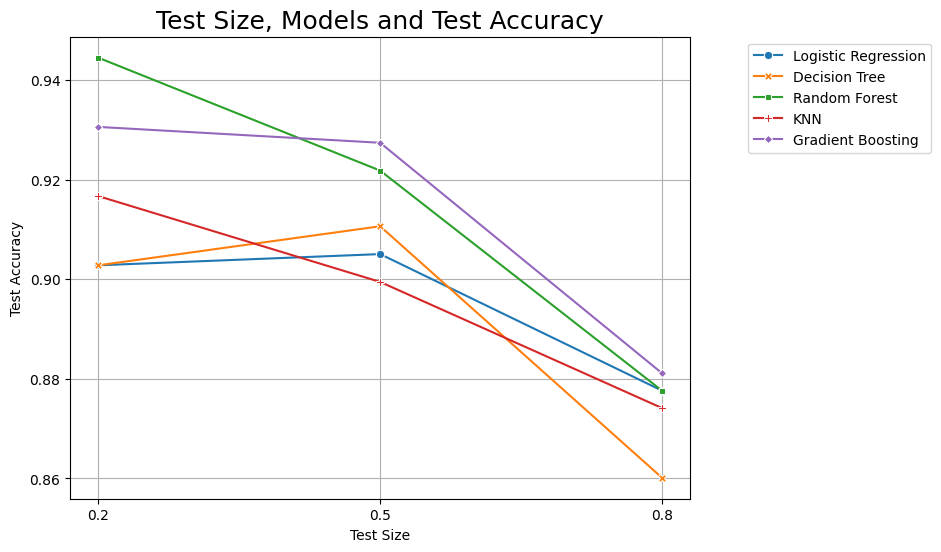

In [46]:
dataset_summary(results)

[[17  2]
 [ 2 51]]


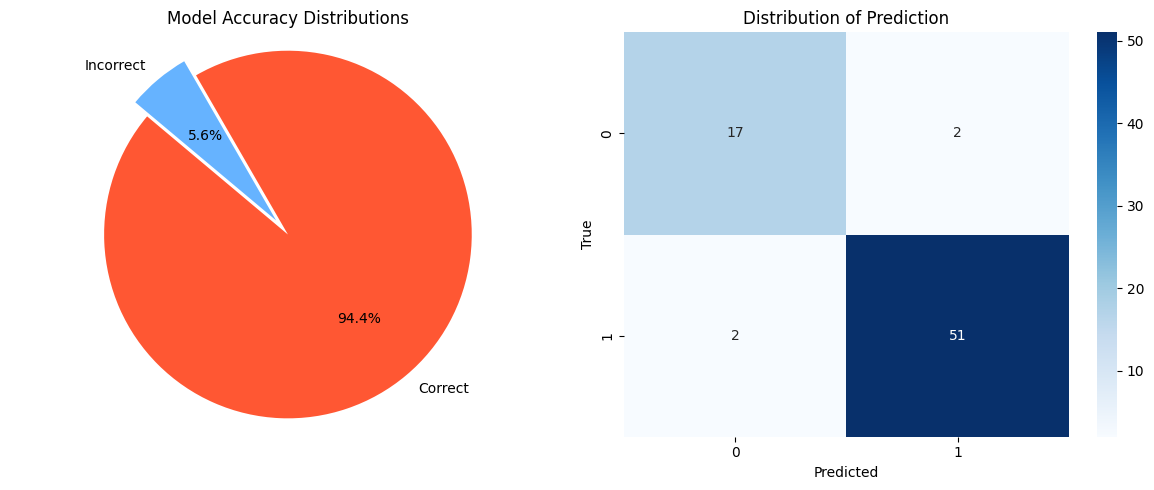

In [47]:
best_acc = results[0]['Test Accuracy'].max()
plot_results(best_acc, best_yi, best_ypred)

## Dataset 3 - Room Occupancy Estimation

In [48]:
total = pd.read_csv('Occupancy_Estimation.csv')

In [49]:
total['Room_Occupancy_Count'].value_counts()

Room_Occupancy_Count
0    8228
2     748
3     694
1     459
Name: count, dtype: int64

In [50]:
# drop Date
total.drop(["Date", 'Time'], axis='columns', inplace=True)

In [51]:
correlation_matrix = total.corr()
correlation_with_occ = correlation_matrix['Room_Occupancy_Count']

In [52]:
# select strong correlation columns as input features
THRESHOLD = 0.5
df_ohe_after_drop_features = total.copy()

for key, value in correlation_with_occ.items():
    if abs(value) < THRESHOLD:
        df_ohe_after_drop_features.drop(columns=key, inplace=True)

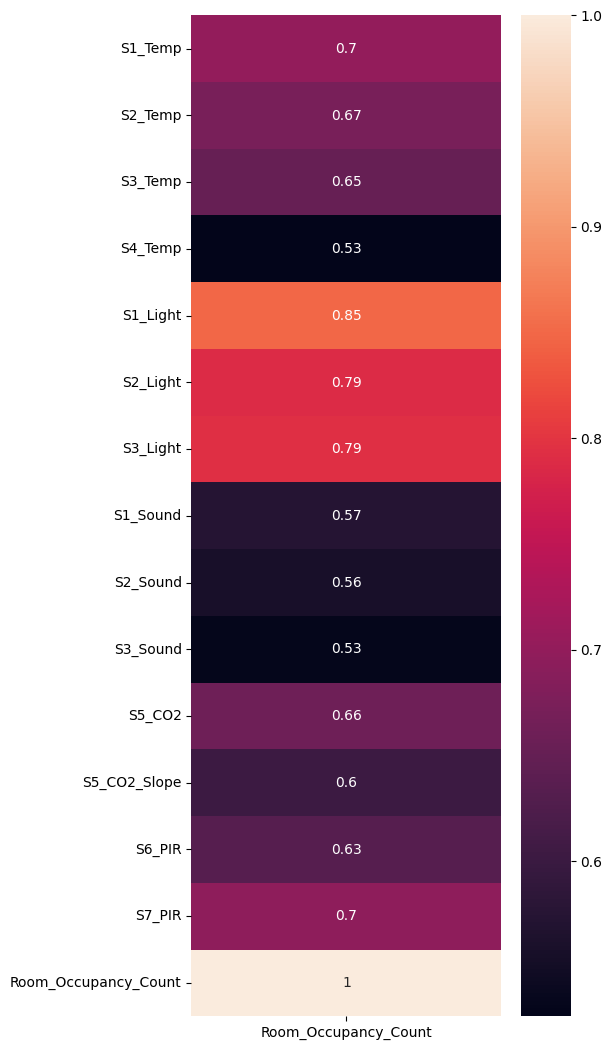

In [53]:
correlation_matrix = df_ohe_after_drop_features.corr()
correlation_with_y = correlation_matrix['Room_Occupancy_Count']

plt.figure(figsize=(5, 13))
sns.heatmap(correlation_with_y.to_frame(), annot=True, cbar=True)
plt.show()

In [54]:
X = df_ohe_after_drop_features.drop(['Room_Occupancy_Count'], axis='columns')
y = df_ohe_after_drop_features['Room_Occupancy_Count'].apply(lambda x : 0 if x == 0 else 1)

In [55]:
results, best_yi, best_ypred, best_para = train_model(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [56]:
best_para

{'max_depth': 50, 'min_samples_leaf': 1, 'n_estimators': 100}

In [57]:
print_results(results)

Test Size: 0.2
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.998025        0.997655      0.996051
Decision Tree                  1.0         0.99963      0.998519
Random Forest                  1.0         0.99963           1.0
KNN                       0.999753        0.999753           1.0
Gradient Boosting              1.0         0.99963      0.998519


Test Size: 0.5
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.998025        0.997038      0.997038
Decision Tree                  1.0         0.99842      0.998815
Random Forest                  1.0        0.999803      0.999605
KNN                            1.0             1.0      0.999408
Gradient Boosting              1.0         0.99921      0.999013


Test Size: 0.8
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.997531        0.996049      0.996051
Decision Tree                  1.0       

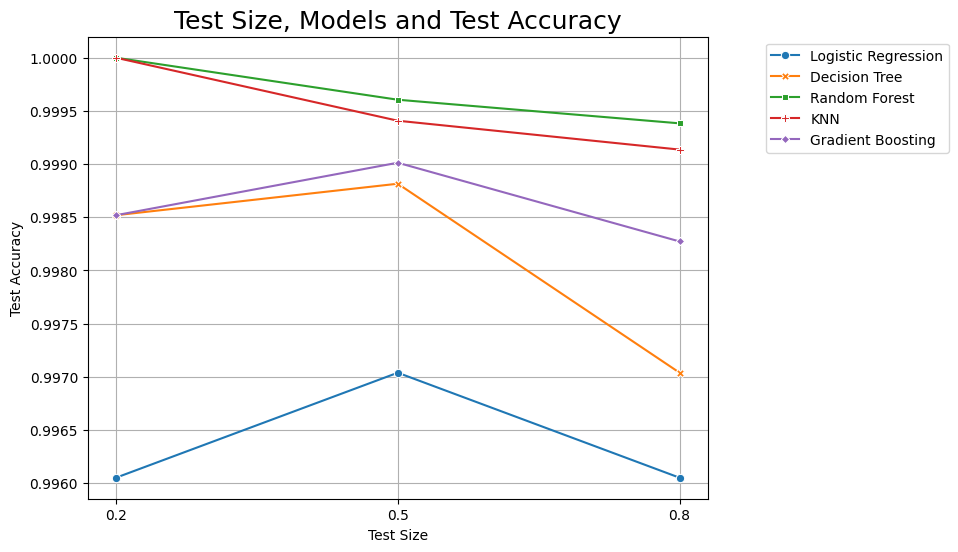

In [58]:
dataset_summary(results)

[[1619    0]
 [   0  407]]


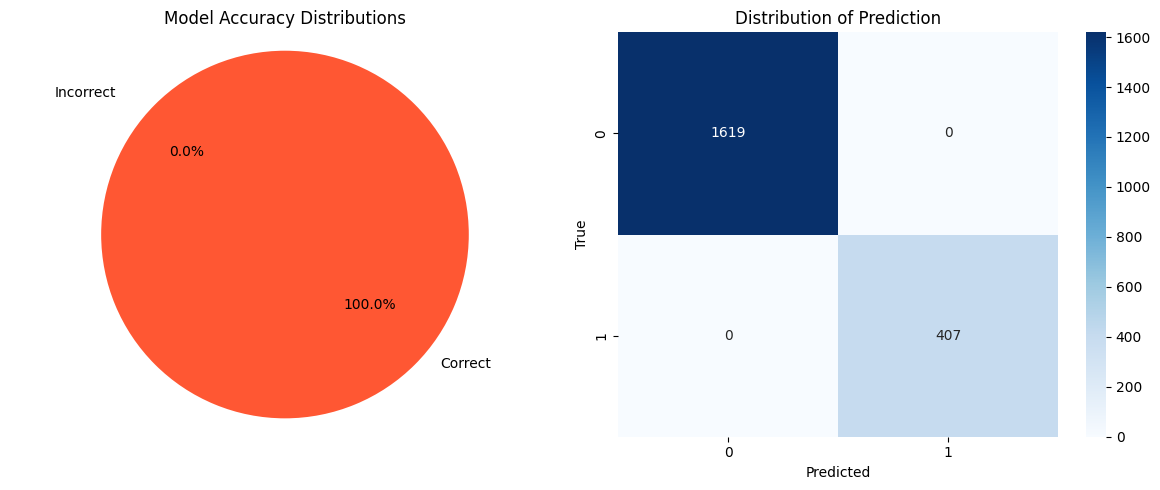

In [59]:
best_acc = results[0]['Test Accuracy'].max()
plot_results(best_acc, best_yi, best_ypred)

## Dataset 4 - Letter Recognition

In [60]:
letter_recognition = fetch_ucirepo(id=59) 

X = letter_recognition.data.features 
y = letter_recognition.data.targets 

total = pd.concat([X, y], axis='columns').dropna().reset_index()
total['lettr'] = total['lettr'].apply(lambda x: 1 if x in ['A', 'E', 'I', 'O', 'U'] else 0)

In [61]:
total.head()

,index,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx,lettr
0,0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8,0
1,1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10,1
2,2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9,0
3,3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8,0
4,4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10,0


In [62]:
len(total)

20000

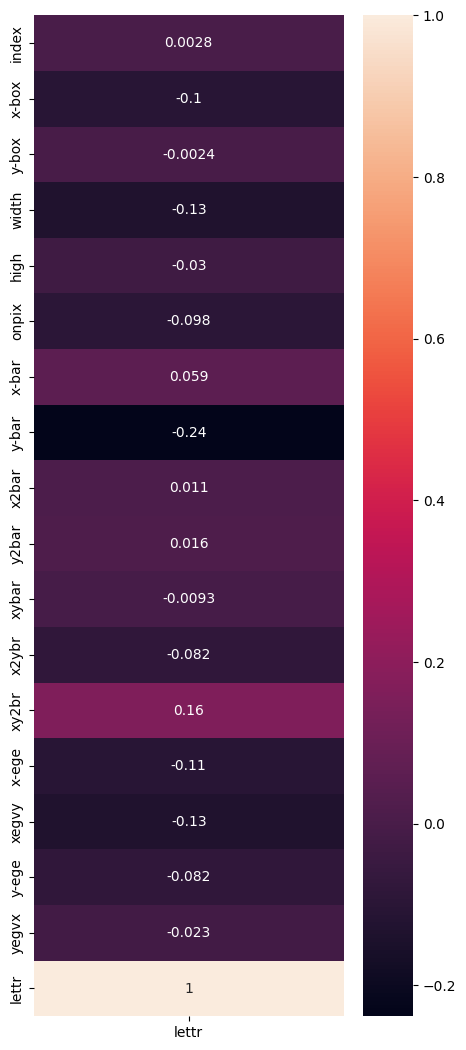

In [63]:
correlation_matrix = total.corr()
correlation_with_y = correlation_matrix['lettr']

plt.figure(figsize=(5, 13))
sns.heatmap(correlation_with_y.to_frame(), annot=True, cbar=True)
plt.show()

In [64]:
X = total.drop(['lettr'], axis='columns')
y = total['lettr']

In [65]:
y.value_counts()

lettr
0    16122
1     3878
Name: count, dtype: int64

In [66]:
results, best_yi, best_ypred, best_para = train_model(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [71]:
best_para

{'loss': 'log_loss', 'max_depth': 10, 'n_estimators': 100}

In [68]:
print_results(results)

Test Size: 0.2
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression       0.695937        0.696437       0.71625
Decision Tree             0.996437        0.948562       0.95225
Random Forest                  1.0        0.967625       0.97675
KNN                        0.80825        0.801625         0.808
Gradient Boosting              1.0        0.975375       0.98175


Test Size: 0.5
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression         0.6978          0.6988        0.7026
Decision Tree                  1.0          0.9374        0.9426
Random Forest                  1.0          0.9597        0.9658
KNN                         0.8107          0.8045        0.8012
Gradient Boosting              1.0          0.9671        0.9757


Test Size: 0.8
                    Train Accuracy Best Validation Test Accuracy
Logistic Regression        0.69075        0.690499      0.695812
Decision Tree                  1.0       

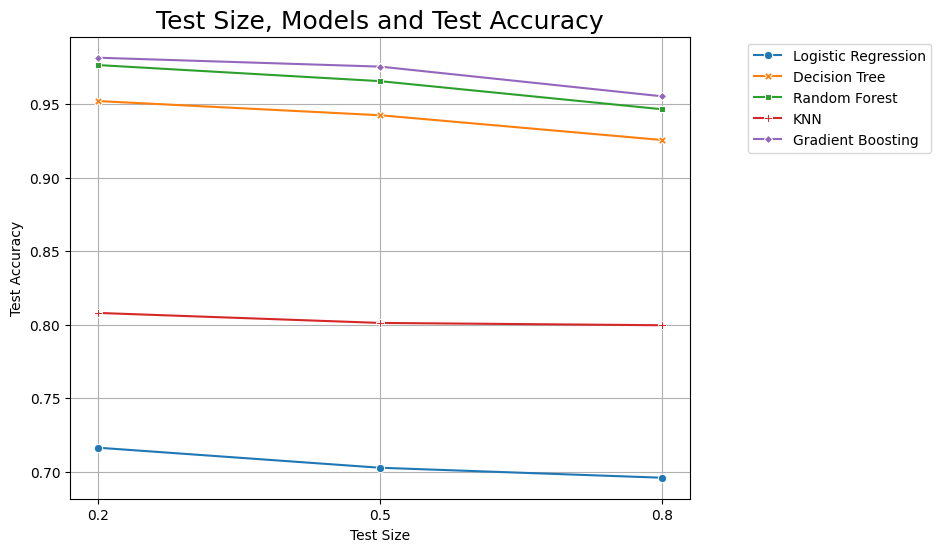

In [69]:
dataset_summary(results)

[[3223   13]
 [  60  704]]


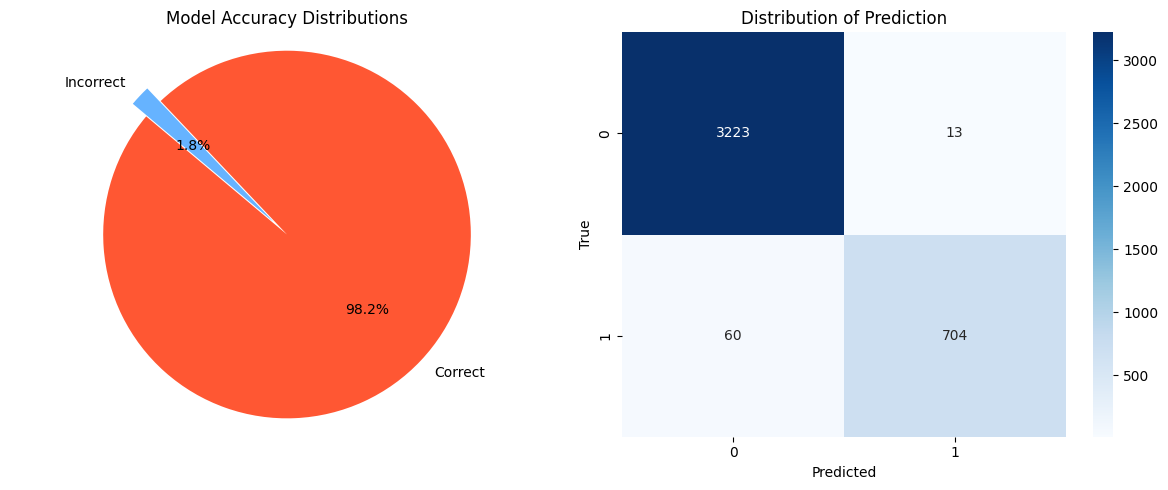

In [70]:
best_acc = results[0]['Test Accuracy'].max()
plot_results(best_acc, best_yi, best_ypred)